## Autoreload

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
import ipywidgets as widgets
from IPython.display import display
from signalepy import plot, settings, utils, analysis

## Parameters

### Accceleration data

**File name and location**

In [ ]:
file_name = 'cable_acceleration.txt'
file_location = utils.get_file_location(file_name)


**Import acceleration data**

In [ ]:
label ='Z'

In [4]:
df = utils.import_sts_acceleration_txt(file_location, label)

Skipping line due to invalid data: POSITION       Time             X1         Y1         Z1         IW1         X2         Y2         Z2         IW2. Error: could not convert string to float: 'Time'


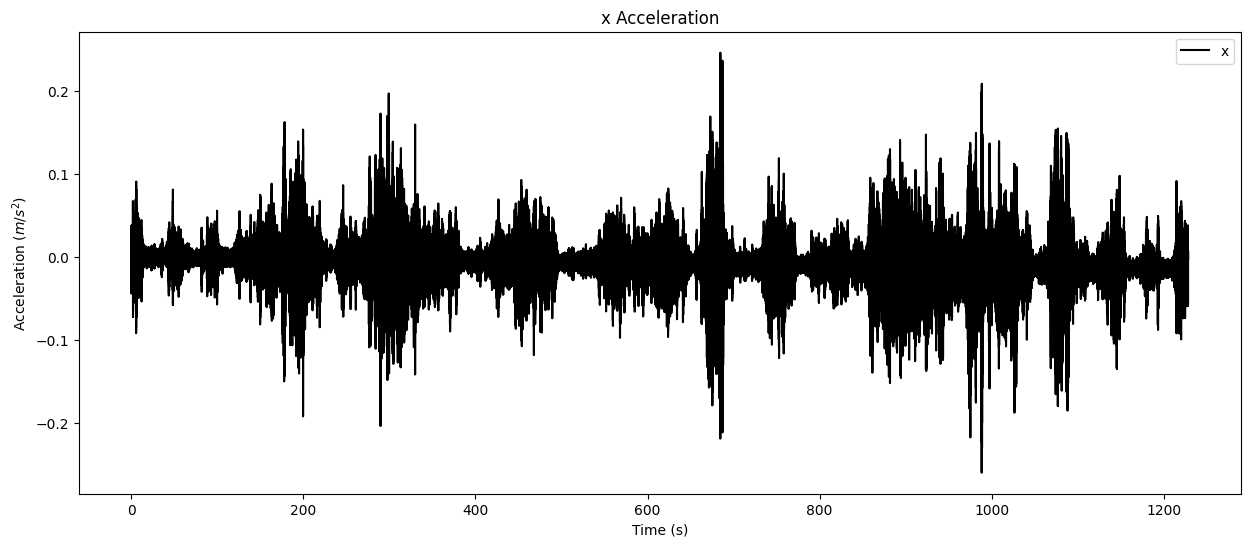

In [5]:
plot.acceleration(df, label, color='k')

## FFT analysis

In [6]:
label_corrected = f'{label}_corrected'
df = analysis.baseline_correction(df, label, label_corrected)

In [7]:
df_fft = analysis.calculate_fft(df, label_corrected)

In [8]:
df_fft

,Frequency,x_corrected Magnitude
0,0.000000,9.410250e-13
1,0.000814,3.912725e+01
2,0.001628,5.358801e+01
3,0.002442,1.042941e+01
4,0.003256,3.243014e+01
...,...,...
122839,99.995523,1.353250e+00
122840,99.996337,1.419466e+00
122841,99.997151,1.071993e+00
122842,99.997965,1.613372e+00


## Denoising

In [23]:
label_filtered= f'{label} filtered'
threshold_percentage = 10
analysis.fft_filter(df=df, threshold_percentage=threshold_percentage, label=label_corrected, label_filtered=label_filtered)

,Time,x Acceleration,x_corrected Acceleration,x filtered Acceleration
0,0.005,0.028421,0.029161,0.011454
1,0.010,0.021700,0.022440,-0.000719
2,0.015,-0.038693,-0.037952,-0.007105
3,0.020,0.002201,0.002942,0.010970
4,0.025,0.017851,0.018592,0.000693
...,...,...,...,...
245684,1228.400,-0.027646,-0.013472,-0.003947
245685,1228.400,-0.004041,0.010133,-0.005624
245686,1228.400,-0.007373,0.006801,0.010261
245687,1228.400,-0.035047,-0.020873,-0.003162


In [24]:
df_fft = analysis.calculate_fft(df, label_filtered)

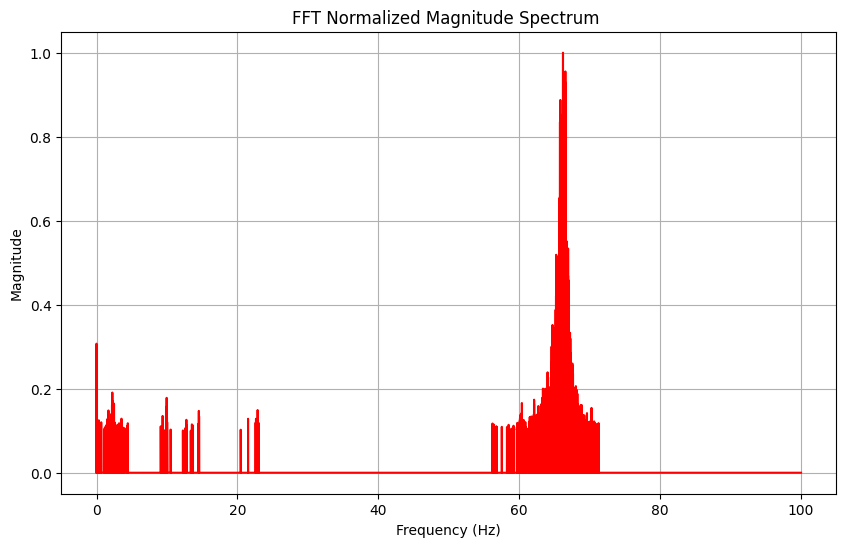

In [25]:
plot.normalized_fft_results(df_fft, label_filtered)

In [26]:
analysis.calculate_fft(df, label)

,Frequency,x Magnitude
0,0.000000,1832.144608
1,0.000814,517.098827
2,0.001628,274.094656
3,0.002442,177.620664
4,0.003256,133.687026
...,...,...
122839,99.995523,1.359947
122840,99.996337,1.422868
122841,99.997151,1.078487
122842,99.997965,1.606739


In [ ]:
wavelet ='morl'
min_scale = 1
max_scale = 16

In [14]:
spectrum, frequencies = analysis.cwt(df, label, wavelet, min_scale, max_scale)

In [15]:
analysis.wavelet_spectrum(df, label_filtered, wavelet, min_scale, max_scale)

interactive(children=(IntSlider(value=0, description='elevation', max=360, step=10), IntSlider(value=0, descri…

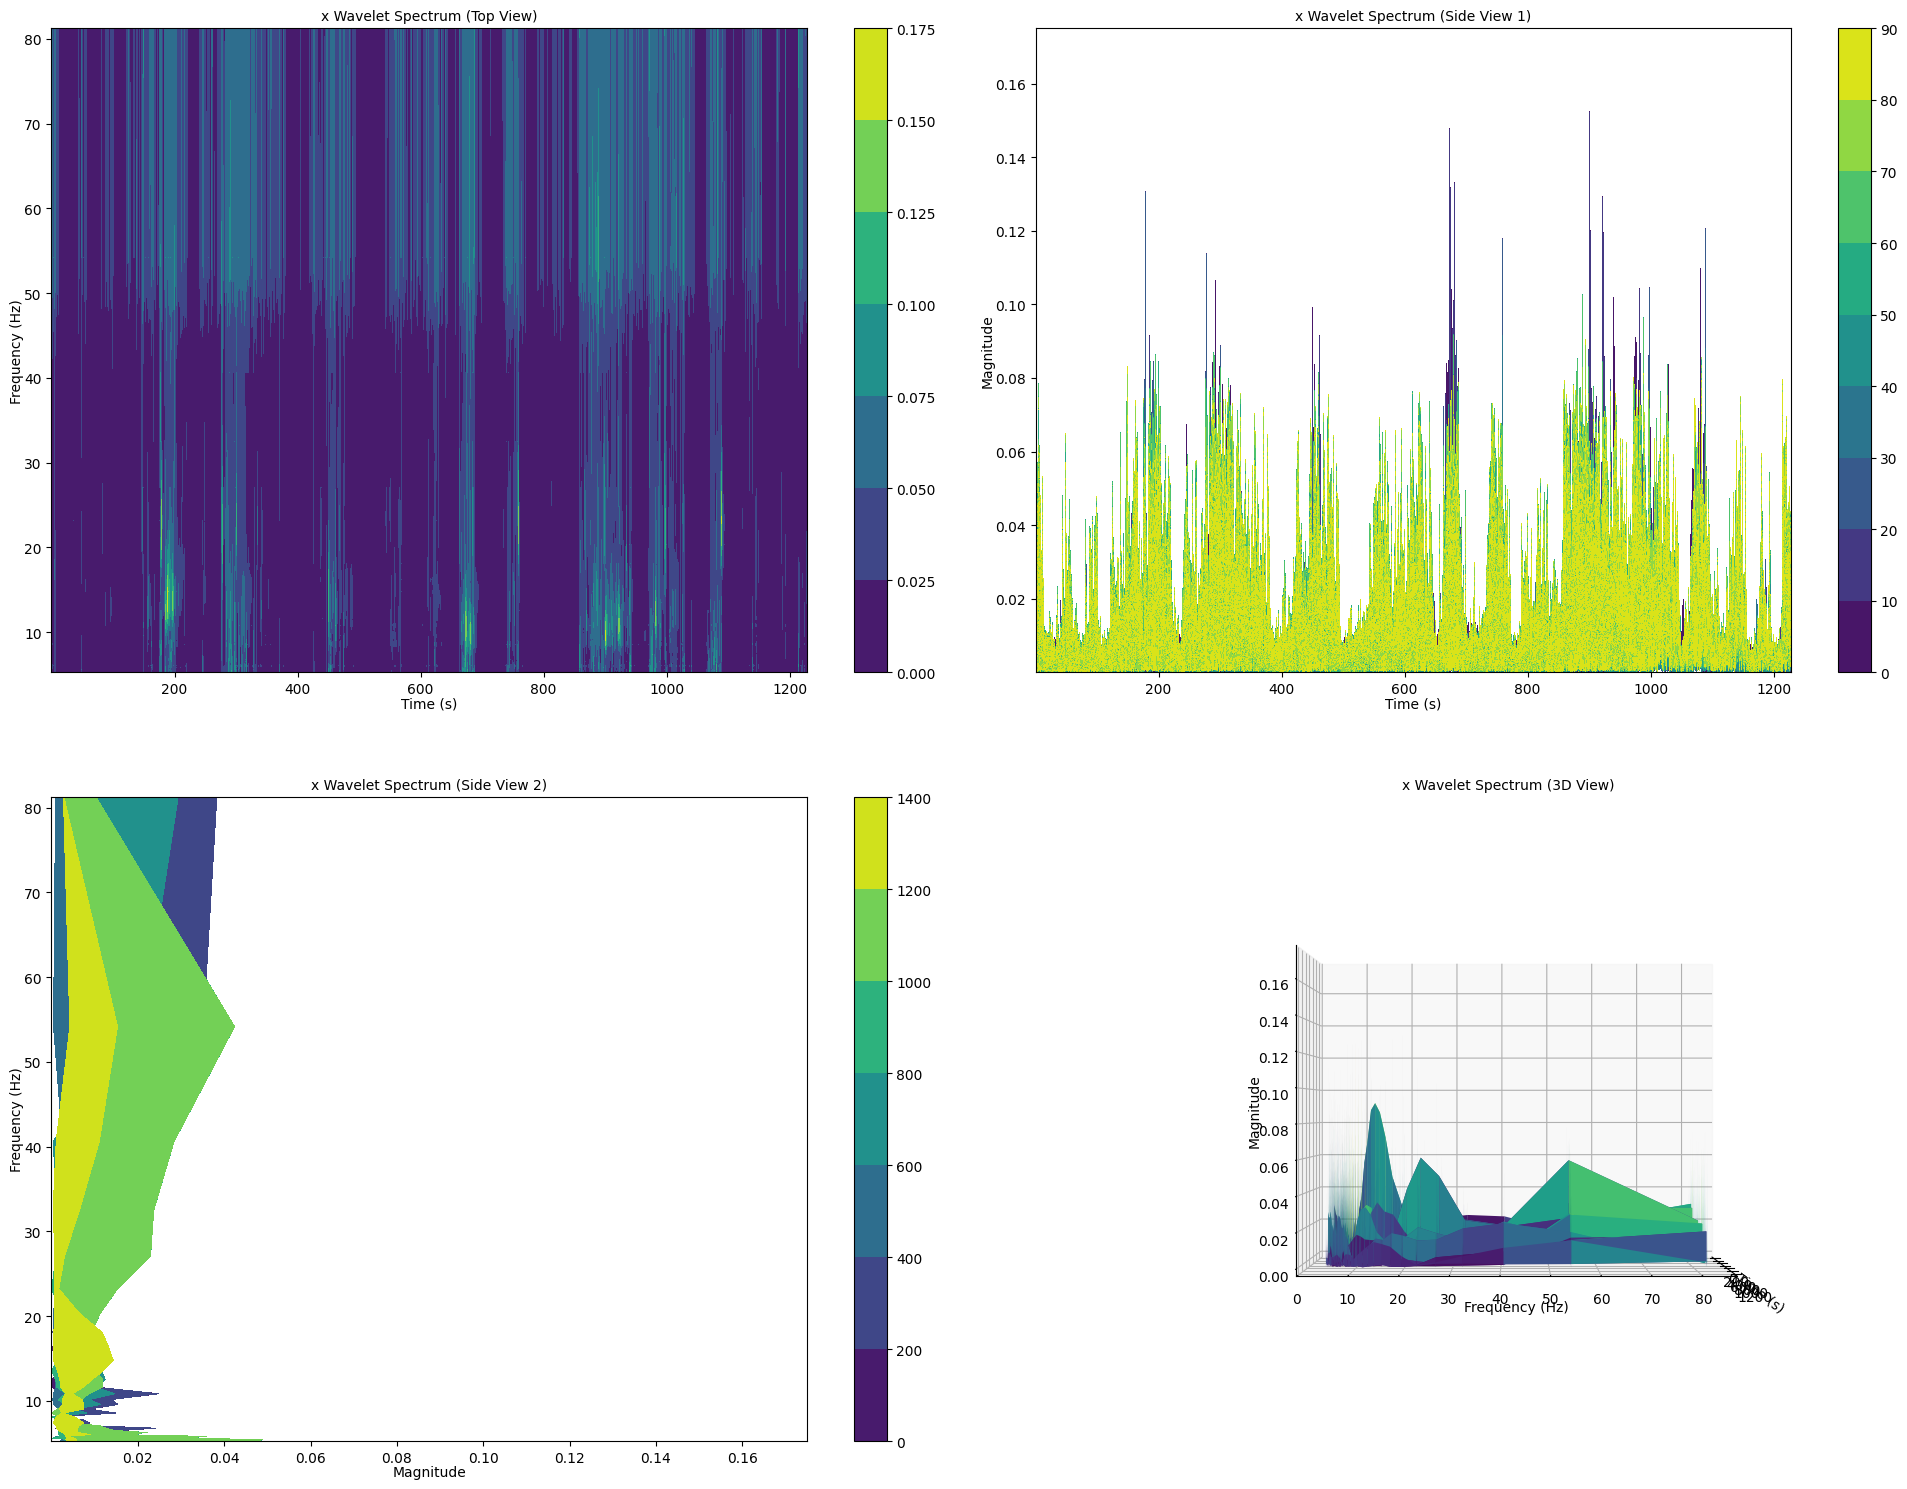

In [16]:
plot.wavelet_spectrum(df, spectrum, frequencies, label)

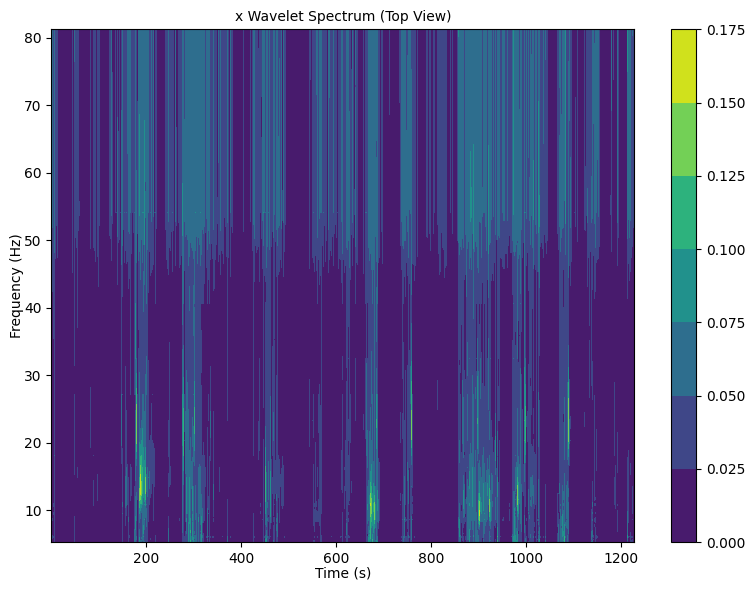

In [17]:
plot.wavelet_spectrum_time_frequency(df, spectrum, frequencies, label)

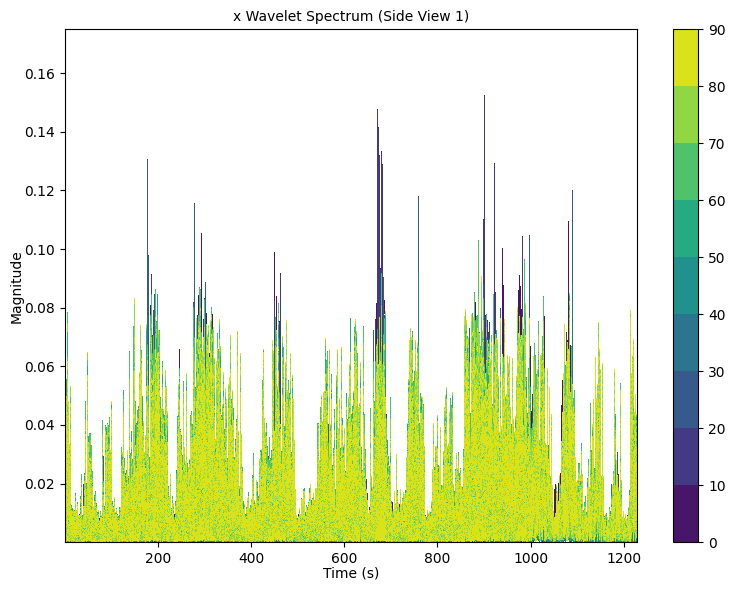

In [18]:
plot.wavelet_spectrum_time_magnitude(df, spectrum, frequencies, label)

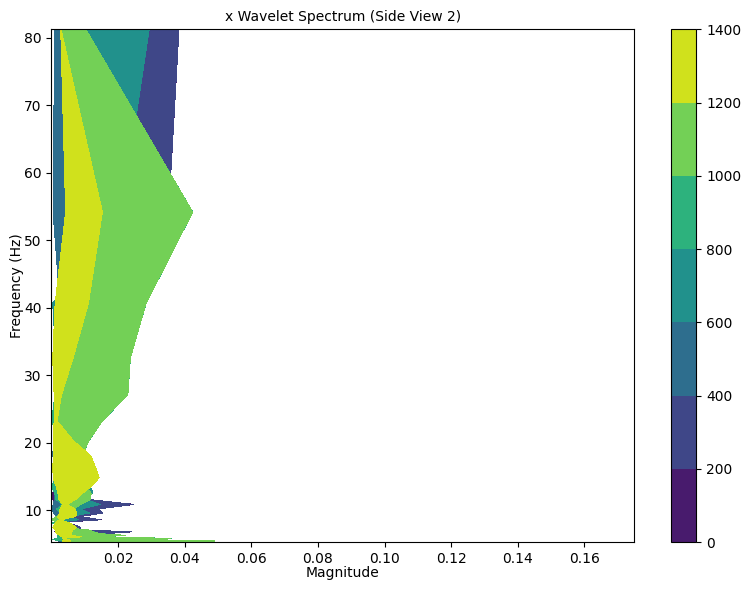

In [19]:
plot.wavelet_spectrum_frequency_magnitude(
    df,
    spectrum,
    frequencies,
    label
)

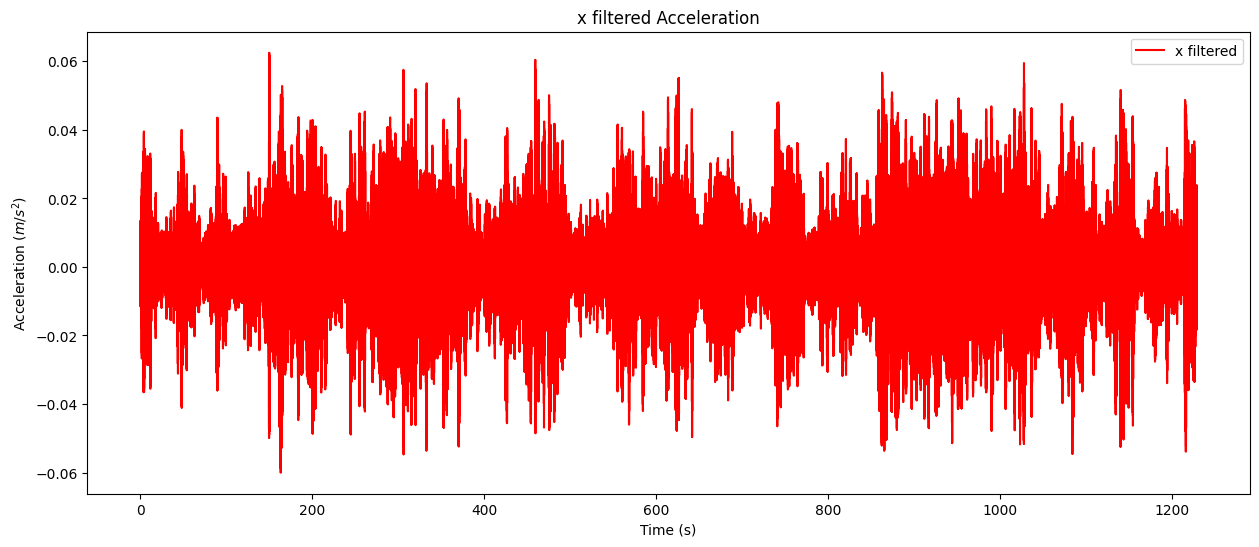

In [20]:
plot.acceleration(df, label_filtered)

In [21]:
df_fft_filtered = analysis.calculate_fft(df, label_filtered)

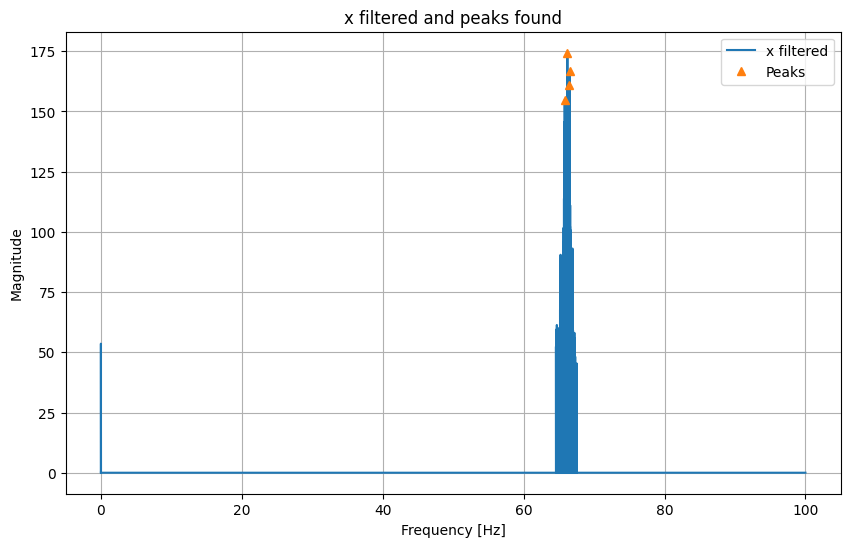

In [22]:
plot.peaks(df_fft, label_filtered, height=150, distance=150)